# **Assignment 3**

In [ ]:
# This cell runs only once. After execution, restart the Kernel before running subsequent cells.
packages = [
    "transformers==4.44.2",
    "datasets==2.19.1",
    "evaluate==0.4.2",
    "peft==0.11.1",
    "accelerate==0.33.0",
    "huggingface-hub>=0.23,<0.25",
    "tokenizers>=0.19,<0.21",
    "safetensors>=0.4"
]

for pkg in packages:
    !pip install -q --no-warn-conflicts "{pkg}"

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, AdamW
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import time
import seaborn as sns
import matplotlib.pyplot as plt
from peft import LoraConfig, get_peft_model, TaskType
from collections import Counter
import re
from nltk.corpus import stopwords

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [15]:
print("Transformers Version:", transformers.__version__)

Transformers Version: 4.44.2


## **Data Input and Preprocessing**

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [5]:
import os

data_dir = "/kaggle/input/sentiment140"
print(os.listdir(data_dir))

['training.1600000.processed.noemoticon.csv']


In [6]:
file_path = os.path.join(data_dir, "training.1600000.processed.noemoticon.csv")
columns = ["sentiment", "ids", "date", "query", "user", "text"]
df = pd.read_csv(file_path, encoding='latin-1', names=columns)

# 0=negative, 1=positive
df = df[df['sentiment'].isin([0, 4])]  
df["label"] = df["sentiment"].apply(lambda x: 0 if x == 0 else 1)

print(df["label"].value_counts())

label
0    800000
1    800000
Name: count, dtype: int64


In [7]:
# Stratified sampling, total of 80,000
n_total = 80000
n_neg = n_total // 2
n_pos = n_total - n_neg

df_negative = df[df['label']==0].sample(n=n_neg, random_state=42)
df_positive = df[df['label']==1].sample(n=n_pos, random_state=42)

df_sampled = pd.concat([df_negative, df_positive]).sample(frac=1, random_state=42)  


print("Sampled label distribution:")
print(df_sampled["label"].value_counts())

Sampled label distribution:
label
1    40000
0    40000
Name: count, dtype: int64


### **Divide Training & Validation**

In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_sampled["text"].tolist(),
    df_sampled["label"].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=df_sampled["label"]
)

In [9]:
print("Train Texts:")
print(train_texts[:5])
print("Train Labels:")
print(train_labels[:5])

print("Val Texts:")
print(val_texts[:5])
print("ValLabels:")
print(val_labels[:5])

Train Texts:
[".also spent the whole night with watching the first season of BONES and fell asleep at 8a.m *lol* .. yeah, I'm nerdy.. so what of it ", "I can't find a job!!!  Anyone want to employ me?", 'iPhone OS 3.0 Beta 5 is the buggiest version yet. Yuk. ', 'Kinda restless. Sleep may not happen just yet... ', "@justineyyy because when he's pissed, he's not going to pretend he isn't.  so go, yoochun! wooot! lol."]
Train Labels:
[1, 0, 0, 0, 1]
Val Texts:
["I've had the most hectic day: meetings, organising flights, trying to organise insurance to go overseas, catching up. No exams != no work ", 'back to work mode.. ', 'o lawd I aont feeln too good. hope I aint got the swines!!!! ', '@Filttr Does your filtering algorithm strip out more updates when the mobile interface is used? Seems that way. (Good!!! ', '@cdeocampo goood morning!!! ']
ValLabels:
[0, 0, 0, 1, 1]


### **Tokenize & Encoding**

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased",
    cache_dir="./distilbert-cache",
    force_download=False
)

# Encoding
train_encodings = tokenizer(
    train_texts,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)
val_encodings = tokenizer(
    val_texts,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

sample_text = train_texts[0]
encoded = tokenizer(sample_text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
print(f"Sample Text：{sample_text}")
print(f"Encoded Lenth：{len(encoded['input_ids'][0])}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Sample Text：.also spent the whole night with watching the first season of BONES and fell asleep at 8a.m *lol* .. yeah, I'm nerdy.. so what of it 
Encoded Lenth：128


### **PyTorch Dataset**

In [11]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

### **DataLoader**

In [12]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

### **Loading the model onto the GPU**

**Full Fine-tuning：**

Using device: cuda


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



 Full Fine-tuning 


Epoch 1/2


Training:   0%|          | 0/4500 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 Time: 466.39 sec
Training Loss: 0.4085 | Validation Loss: 0.3728
Validation | Accuracy: 0.8334 | F1: 0.8332 | Precision: 0.8348 | Recall: 0.8334
----------------------------------------------------------------------

Epoch 2/2


Training:   0%|          | 0/4500 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 Time: 466.27 sec
Training Loss: 0.3037 | Validation Loss: 0.3812
Validation | Accuracy: 0.8371 | F1: 0.8369 | Precision: 0.8388 | Recall: 0.8371
----------------------------------------------------------------------

=== Final Summary (Full Fine-tuning) ===
Total Training Time: 15.54 min
Average Time per Epoch: 466.33 sec
Average Training Loss: 0.3561
Average Validation Loss: 0.3770

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.87      0.84      4000
    positive       0.86      0.80      0.83      4000

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



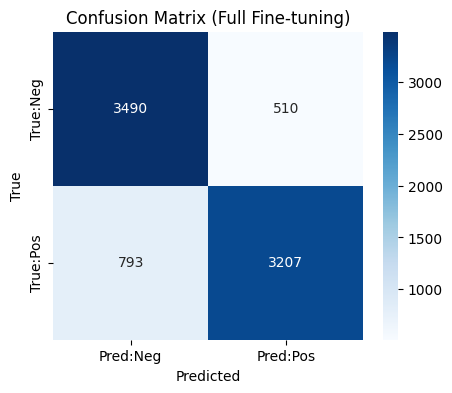

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Dataset & Dataloader
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_labels)
)
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_labels)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialization & Optimization
full_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2  # 二分类
)
full_model.to(device)
optimizer = AdamW(full_model.parameters(), lr=2e-5)

# Training Loop
epochs = 2
train_loss_history, val_loss_history = [], []
epoch_times = []

print("\n Full Fine-tuning \n")
start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{epochs}")

    # === Training ===
    full_model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = full_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # === Validation ===
    full_model.eval()
    total_val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = full_model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1} Time: {epoch_time:.2f} sec")
    print(f"Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation | Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("-" * 70)

total_time = time.time() - start_time

# Summary
print("\n=== Final Summary (Full Fine-tuning) ===")
print(f"Total Training Time: {total_time/60:.2f} min")
print(f"Average Time per Epoch: {np.mean(epoch_times):.2f} sec")
print(f"Average Training Loss: {np.mean(train_loss_history):.4f}")
print(f"Average Validation Loss: {np.mean(val_loss_history):.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["negative", "positive"]))

# Confusion Matrix
cm_full = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred:Neg", "Pred:Pos"],
            yticklabels=["True:Neg", "True:Pos"])
plt.title("Confusion Matrix (Full Fine-tuning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


**Partial Fine-tuning**

***LoRA***

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 LoRA Fine-tuning 


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/4500 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 Time: 317.87 sec
Training Loss: 0.4717 | Validation Loss: 0.4265
Validation | Accuracy: 0.8033 | F1: 0.8031 | Precision: 0.8043 | Recall: 0.8033
----------------------------------------------------------------------

Epoch 2/2


Training:   0%|          | 0/4500 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 Time: 318.12 sec
Training Loss: 0.4250 | Validation Loss: 0.4117
Validation | Accuracy: 0.8121 | F1: 0.8118 | Precision: 0.8146 | Recall: 0.8121
----------------------------------------------------------------------

=== Final Summary (LoRA Fine-tuning) ===
Total Training Time: 10.60 min
Average Time per Epoch: 318.00 sec
Average Training Loss: 0.4483
Average Validation Loss: 0.4191

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.86      0.82      4000
    positive       0.84      0.77      0.80      4000

    accuracy                           0.81      8000
   macro avg       0.81      0.81      0.81      8000
weighted avg       0.81      0.81      0.81      8000



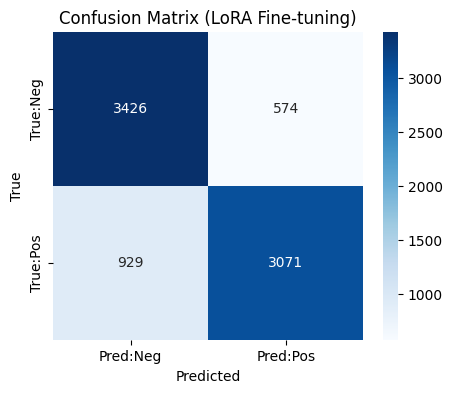

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Dataset & Dataloader
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_labels)
)
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_labels)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialization
base_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # LoRA rank
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"]  
)

lora_model = get_peft_model(base_model, lora_config)
lora_model.to(device)

optimizer = AdamW(lora_model.parameters(), lr=2e-5)

# Training Loop
epochs = 2
train_loss_history, val_loss_history = [], []
epoch_times = []

print("\n LoRA Fine-tuning \n")
start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{epochs}")

    lora_model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = lora_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    lora_model.eval()
    total_val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = lora_model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1} Time: {epoch_time:.2f} sec")
    print(f"Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation | Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("-" * 70)

total_time = time.time() - start_time

# Summary
print("\n=== Final Summary (LoRA Fine-tuning) ===")
print(f"Total Training Time: {total_time/60:.2f} min")
print(f"Average Time per Epoch: {np.mean(epoch_times):.2f} sec")
print(f"Average Training Loss: {np.mean(train_loss_history):.4f}")
print(f"Average Validation Loss: {np.mean(val_loss_history):.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["negative", "positive"]))

# Confusion Matrix
cm_lora = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_lora, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred:Neg", "Pred:Pos"],
            yticklabels=["True:Neg", "True:Pos"])
plt.title("Confusion Matrix (LoRA Fine-tuning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


***Classifier-only Fine-tuning***

Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Classifier-only Fine-tuning 


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/4500 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 Time: 156.25 sec
Training Loss: 0.6266 | Validation Loss: 0.5865
Validation | Accuracy: 0.6950 | F1: 0.6917 | Precision: 0.7038 | Recall: 0.6950
----------------------------------------------------------------------

Epoch 2/2


Training:   0%|          | 0/4500 [00:00<?, ?it/s]

Validating:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2 Time: 156.46 sec
Training Loss: 0.5828 | Validation Loss: 0.5598
Validation | Accuracy: 0.7156 | F1: 0.7149 | Precision: 0.7179 | Recall: 0.7156
----------------------------------------------------------------------

=== Final Summary (Classifier-only Fine-tuning) ===
Total Training Time: 5.21 min
Average Time per Epoch: 156.35 sec
Average Training Loss: 0.6047
Average Validation Loss: 0.5731

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.66      0.70      4000
    positive       0.70      0.77      0.73      4000

    accuracy                           0.72      8000
   macro avg       0.72      0.72      0.71      8000
weighted avg       0.72      0.72      0.71      8000



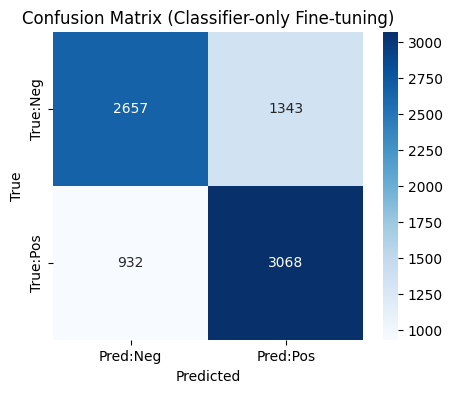

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Dataset & Dataloader
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_labels)
)
val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_labels)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Initialization
partial_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2 
)

# Freeze
for param in partial_model.distilbert.parameters():
    param.requires_grad = False

optimizer = AdamW(partial_model.classifier.parameters(), lr=2e-4)
partial_model.to(device)

epochs = 2
train_loss_history, val_loss_history = [], []
epoch_times = []

print("\n Classifier-only Fine-tuning \n")
start_time = time.time()

for epoch in range(epochs):
    epoch_start = time.time()
    print(f"\nEpoch {epoch+1}/{epochs}")

    partial_model.train()
    total_train_loss = 0.0
    progress_bar = tqdm(train_loader, desc="Training", leave=False)

    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = partial_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    partial_model.eval()
    total_val_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = partial_model(input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1} Time: {epoch_time:.2f} sec")
    print(f"Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation | Accuracy: {acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print("-" * 70)

total_time = time.time() - start_time

# Summary
print("\n=== Final Summary (Classifier-only Fine-tuning) ===")
print(f"Total Training Time: {total_time/60:.2f} min")
print(f"Average Time per Epoch: {np.mean(epoch_times):.2f} sec")
print(f"Average Training Loss: {np.mean(train_loss_history):.4f}")
print(f"Average Validation Loss: {np.mean(val_loss_history):.4f}")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["negative", "positive"]))

# Confusion Matrix
cm_partial = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_partial, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred:Neg", "Pred:Pos"],
            yticklabels=["True:Neg", "True:Pos"])
plt.title("Confusion Matrix (Classifier-only Fine-tuning)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## **Error Analysis**

/tmp/ipykernel_158/3839678837.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


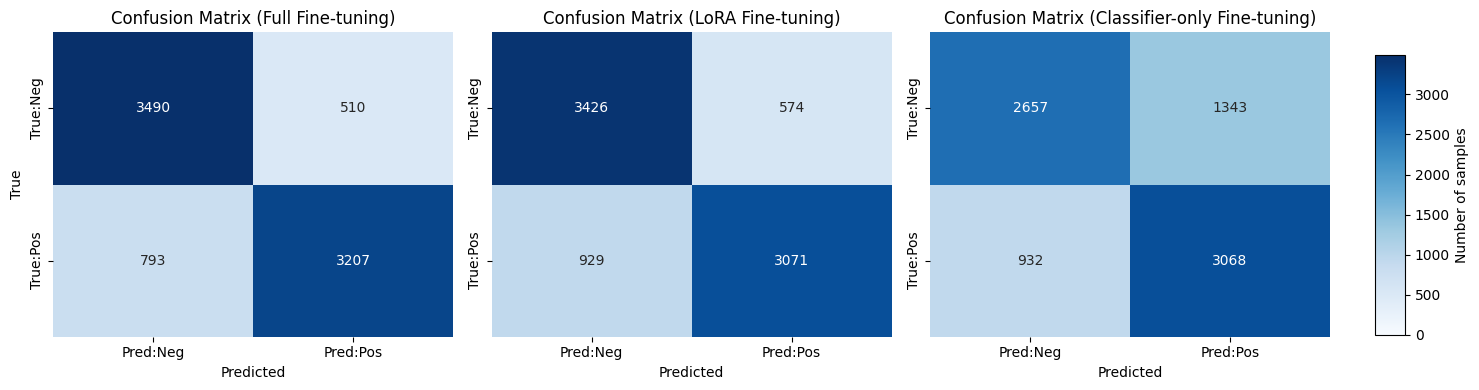

In [21]:
cms = [cm_full, cm_lora, cm_partial]
titles = ["Full Fine-tuning", "LoRA Fine-tuning", "Classifier-only Fine-tuning"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

vmax = max(cm.max() for cm in cms)

for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred:Neg", "Pred:Pos"],
                yticklabels=["True:Neg", "True:Pos"],
                cbar=False,
                vmin=0, vmax=vmax,
                ax=ax)
    ax.set_title(f"Confusion Matrix ({title})")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True" if ax == axes[0] else "")

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, label="Number of samples")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


In [28]:
stop_words = set(stopwords.words('english'))

def analyze_errors_with_text_features(model, dataloader, texts, device, 
                                      label_names=None, top_n=10, max_words=20,
                                      ax=None, title="Error Text Length Distribution"):
    model.eval()
    all_preds, all_labels, all_texts = [], [], []

    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Analyzing errors")):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        start_idx = batch_idx * dataloader.batch_size
        end_idx = start_idx + len(labels)
        all_texts.extend(texts[start_idx:end_idx])

    df_results = pd.DataFrame({
        "text": all_texts,
        "true_label": all_labels,
        "pred_label": all_preds
    })
    df_errors = df_results[df_results["true_label"] != df_results["pred_label"]]
    top_errors = df_errors.head(top_n)

    error_counts = df_errors["true_label"].value_counts()
    total_counts = df_results["true_label"].value_counts()
    error_rate_by_class = (error_counts / total_counts).fillna(0)

    # Length
    df_errors['text_length'] = df_errors['text'].apply(lambda x: len(x.split()))
    length_counts = df_errors['text_length'].value_counts().sort_index()
    
    x = length_counts.index
    y = length_counts.values
    
    if ax is None:
        plt.figure(figsize=(8,4))
        ax = plt.gca()
    
    ax.bar(x, y, color='skyblue', edgecolor='none')
    ax.set_xlabel("Number of Words")
    ax.set_ylabel("Frequency") 
    ax.set_title(title)
    ax.tick_params(axis='x')


    # Top-10 Words
    words = []
    for text in df_errors['text']:
        text_clean = re.sub(r'[^\w\s]', '', text.lower())
        words.extend([w for w in text_clean.split() if w not in stop_words])
    word_counts = Counter(words)
    print(f"Top {max_words} frequent words in error texts:")
    for w, c in word_counts.most_common(max_words):
        print(f'"{w}": {c}')

    print("\n=== Example error texts for top frequent words with true labels ===")
    example_dict = {}
    
    label_map = {0: "negative", 1: "positive"} 
    
    for w, _ in word_counts.most_common(5):  
        examples = df_errors[df_errors['text'].str.contains(rf'\b{w}\b', case=False, na=False)][['text','true_label']].head(3)
        example_dict[w] = examples
    
        print(f'\nWord: "{w}"')
        for i, row in examples.iterrows():
            text_snip = row['text'][:150] + ("..." if len(row['text']) > 150 else "")
            label_str = label_map.get(row['true_label'], str(row['true_label']))
            print(f'  {i+1}. [{label_str}] {text_snip}')


    return top_errors, df_errors

Analyzing errors:   0%|          | 0/250 [00:00<?, ?it/s]

Top 10 frequent words in error texts:
"im": 148
"get": 79
"like": 73
"dont": 70
"lol": 69
"back": 64
"work": 62
"day": 60
"time": 59
"go": 57

=== Example error texts for top frequent words with true labels ===

Word: "im"
  248. [positive] early zzzzzzzzzzzzzzz..............im sooo inspired  in life you cant let the small stuff get to ya!!
  326. [negative] I think so  re: http://ff.im/3Cdsp
  391. [negative] @BBIZZYYY sounds like we both need some snuggles  sorry hun, but ur young &amp; beautiful &amp; Im sure theres something amazing awaiting you!

Word: "get"
  13. [negative] bed...sorta. today was good, sara has strep thought Angelina does to; i shared a water with her B4 they told me, i will prob get it to 
  26. [positive] @Alyssa_Milano Darn you and your Dodgers!!!!!!!! Good game good game. Tomorrow you get a day game in Wrigley, I am predicting a Cubs win! 
  248. [positive] early zzzzzzzzzzzzzzz..............im sooo inspired  in life you cant let the small stuff get to ya!!



/tmp/ipykernel_158/204715583.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_errors['text_length'] = df_errors['text'].apply(lambda x: len(x.split()))


Analyzing errors:   0%|          | 0/250 [00:00<?, ?it/s]

Top 10 frequent words in error texts:
"im": 193
"get": 84
"dont": 83
"lol": 81
"like": 78
"day": 76
"one": 66
"work": 66
"back": 64
"time": 63

=== Example error texts for top frequent words with true labels ===

Word: "im"
  326. [negative] I think so  re: http://ff.im/3Cdsp
  391. [negative] @BBIZZYYY sounds like we both need some snuggles  sorry hun, but ur young &amp; beautiful &amp; Im sure theres something amazing awaiting you!
  619. [positive] @Rosherrrs the same trust me - without the exams - im a final yr med student here so gotta buckle up  been studying all week ... lol

Word: "get"
  13. [negative] bed...sorta. today was good, sara has strep thought Angelina does to; i shared a water with her B4 they told me, i will prob get it to 
  316. [negative] @MBGsam  oh dear...lots of cuddles,snuggles,hugs kisses for her!and get well soon!
  380. [positive] awwwwwwwwwwww =( i sorry. you get a room! and a free ice cream cone..... with sprinkles 

Word: "dont"
  22. [negative] @Rocki

/tmp/ipykernel_158/204715583.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_errors['text_length'] = df_errors['text'].apply(lambda x: len(x.split()))


Analyzing errors:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_158/204715583.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_errors['text_length'] = df_errors['text'].apply(lambda x: len(x.split()))


Top 10 frequent words in error texts:
"im": 283
"get": 122
"go": 121
"like": 113
"dont": 111
"lol": 100
"time": 97
"love": 95
"day": 95
"good": 94

=== Example error texts for top frequent words with true labels ===

Word: "im"
  133. [positive] @RobEctor Im everywhere  lol...How you been?
  326. [negative] I think so  re: http://ff.im/3Cdsp
  385. [negative] @michelleday a;sdlfjka;slkdfj FU. i cant believe im grounded and i missed coldplay. TWICE! both times!  wow. fml

Word: "get"
  223. [negative] It's too earlyyyy to get up!!  xx
  316. [negative] @MBGsam  oh dear...lots of cuddles,snuggles,hugs kisses for her!and get well soon!
  383. [negative] @the_carl Sounds like I missed a great time tonight  Had a good time here but can't wait to get home.

Word: "go"
  241. [negative] back 2 wrk! it sux!  cant wait to go bk hm to wifey!
  343. [negative] @GabrielaValella Date last night, Nephew's 1st birthday party today (Yay!), &amp; my 5K run tom. I SO want to go out tonight, but I must r

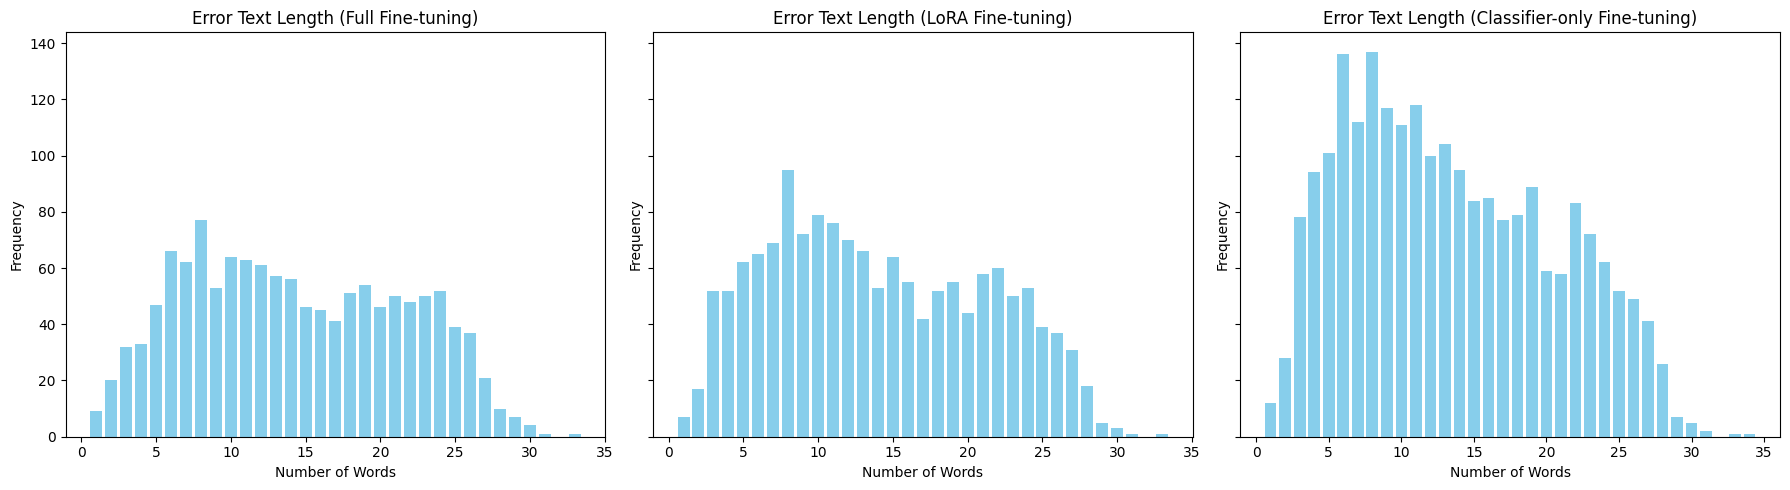

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True) 

models = [full_model, lora_model, partial_model]
dataloaders = [val_loader, val_loader, val_loader]
texts_list = [val_texts, val_texts, val_texts]  
titles = ["Full Fine-tuning", "LoRA Fine-tuning", "Classifier-only Fine-tuning"]

all_top_errors, all_df_errors = [], []

for i, (model, dataloader, texts) in enumerate(zip(models, dataloaders, texts_list)):
    top_errors, df_errors = analyze_errors_with_text_features(
        model, dataloader, texts, device,
        top_n=10, max_words=10,
        ax=axs[i],
        title=f"Error Text Length ({titles[i]})"
    )
    all_top_errors.append(top_errors)
    all_df_errors.append(df_errors)

plt.tight_layout()
plt.show()
